### NOTES
Make sure that the order of answers is correct on the plot and that the answers that no one chose (0) are also represented - this info is available in the questions file. The axis of the plots should always be clear (labeled).

### TASK 2
Load the two files into Pandas DataFrames. Make sure that the answers "None" are not interpreted as NaN by Pandas.

#### Explanation
We import pandas library which will be used to read data from files.

We use `read_csv` function to read files and we want to keep **None** values as strings so we pass `keep_default_na=False` as a parameter.

We use this function to read both files.

If there is any missing values we use `fillna` function to fill them in as a **None** string.

In [2]:
import pandas as pd

qf = pd.read_csv('questions.csv', keep_default_na=False)
rf = pd.read_csv('responses.csv', keep_default_na=False)

rf.fillna('None', inplace=True)
qf.fillna('None', inplace=True)

### TASK 3
Produce a bar plot of response frequencies to the second question "What is your level of programming experience?", for year 2024.

#### Explanation
1. We declare some constants for the question name and the year. 
2. We get all answers for specific question from responses and count them up.
3. We add missing answers if there was any.
4. Plot the graph.

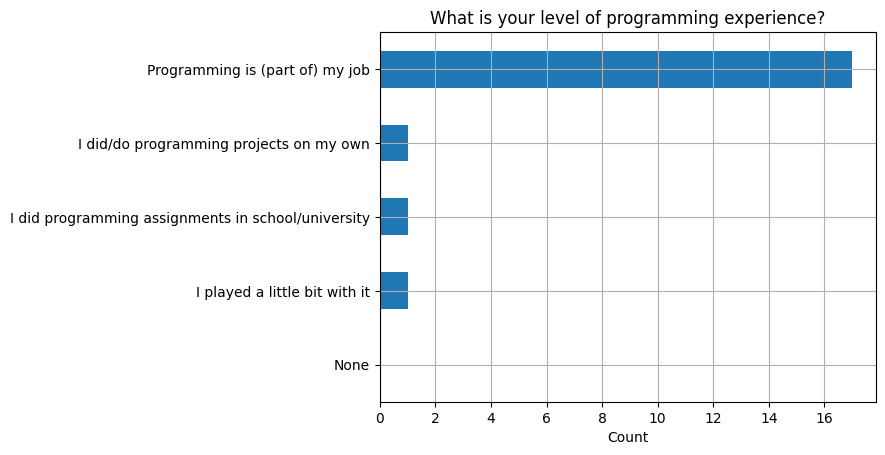

In [23]:
import matplotlib.pyplot as plt
QUESTION_NAME = 'What is your level of programming experience?'
QUESTION_YEAR = 2024

# Get all specific year question responses and count them up
rf_2024 = rf[rf['Year'] == QUESTION_YEAR][QUESTION_NAME].value_counts()

# Get all possible answers
questions = qf[qf['Question'] == QUESTION_NAME]['Answer']

# Make sure that all the answers are included in the results
for question in questions:
    if question not in rf_2024:
        rf_2024[question] = 0

# Plot horizontal bar chart
rf_2024.plot(kind='barh', color='#1F77B4', grid=True)

# Invert y axis to change order to decending
plt.gca().invert_yaxis()

# Add labels and title
plt.xlabel('Count')
plt.ylabel(None)
plt.title(QUESTION_NAME)

# Show plot
plt.show()

### TASK 4
Produce a similar bar plot for a different question, but with values for all the years 2020-2024 in a single plot, as bars of different colors for the different years, next to each other.

#### Explanation
To do this we first need to get all possible years and responses. Then we make a template with zeroes. We process real data to get the set and then we merge it with the template so that if real data was missing some responses it will be set to 0. After that we just need to draw the bar chart.

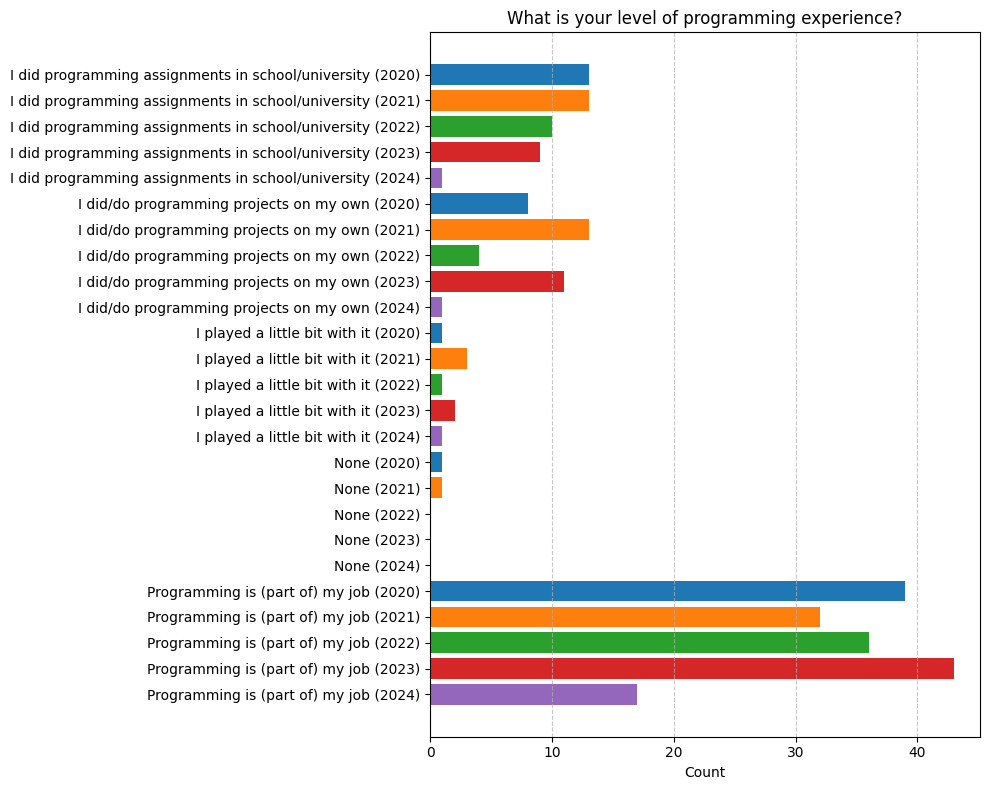

In [3]:
import matplotlib.pyplot as plt
# import itertools
QUESTION_NAME = 'What is your level of programming experience?'
QUESTION_YEAR = "Year"

GROUP_BY = [QUESTION_NAME, 'Year']

# Get all possible answers
questions = qf[qf['Question'] == QUESTION_NAME]['Answer']
years = rf['Year'].unique()

# Creating all possible question year combinations and assigning value 0
template_data = pd.MultiIndex.from_product(
    [questions.values, years], names=[QUESTION_NAME, "Year"]
).to_frame(
    index=False
).groupby(
    GROUP_BY
).apply(
    lambda x: 0
, include_groups=False).rename("template")

# Group all responses by question name and year and get their counts for a specific question
groups = rf.groupby(GROUP_BY)[QUESTION_NAME].value_counts()

# Reset the index and prepare for merging
template_data = template_data.reset_index()

# Do an outer join merge so that if groups missing data gets filled with 0's
merged = pd.merge(
    template_data, 
    groups, 
    on=GROUP_BY,
    how='left'
)

# After merge some values are NaN so we fill it in with 0
merged['count'] = merged['count'].fillna(0)

# Drop the template column which has only zeros
merged = merged.drop(columns='template')

# Plot horizontal bar chart
merged['question_year'] = merged[QUESTION_NAME] + " (" + merged['Year'].astype(str) + ")"

# Using color map to set each year bar color
cmap = plt.get_cmap('tab10')
colors = {year: cmap(i) for i, year in enumerate(years)}
bar_colors = merged['Year'].map(colors)

plt.figure(figsize=(10, 8))  # Set figure size
plt.barh(merged['question_year'], merged['count'], color=bar_colors)

# # Invert y axis to change order to decending
plt.gca().invert_yaxis()

# # Add labels and title
plt.xlabel('Count')
plt.ylabel(None)
plt.title(QUESTION_NAME)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# # Show plot
plt.tight_layout()
plt.show()

### TASK 5
Compute weighted averages for each question and year, averaging the weights of the answers instead of their string values. You should get a single number for each question-year combination. Visualise in a simple line plot how some of those values changed over the years.

#### EXPLANATION
We group each response by year, then we go over each response columns because that's where the question name is. We skip the year because we use it for grouping. Other column names are used to get all group column counts for each year. Then we get the weight of each answer from questions dataframe and multiply it by counts to get each year questions answer weights. Now that we have weights and counts we calculate averages for each questions and year. Finally we just need to visualize the data. We plot the lines and set the labels.

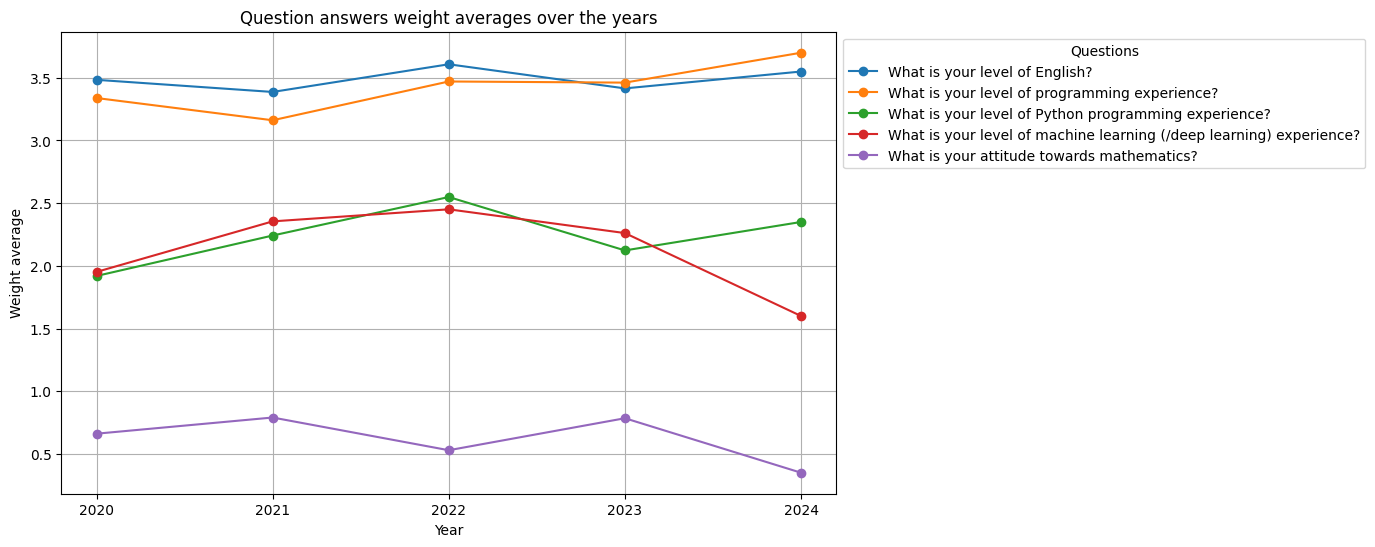

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Initialize values
counts = {}
weights = {}
averages = {}
groups = rf.groupby('Year')

# Iterate over each column except 'Year'
for col in rf.columns:
    if col != 'Year':
        # Group by 'Year' and count occurrences of each unique value in the column
        counts[col] = groups[col].value_counts().unstack(fill_value=0)
        weights[col] = {}

        # Calculate weights for each question answer
        for answer in counts[col]:
            weight = int(qf[(qf['Question'] == col) & (qf['Answer'] == answer)]['Answer weight'].iloc[0])
            weights[col][answer] = counts[col][answer] * weight
        
        # Calculate question averages
        averages[col] = pd.DataFrame(weights[col]).sum(axis=1) / counts[col].sum(axis=1)
        
# Create the plot
plt.figure(figsize=(10, 6))

# Plot each line from dataframe
for label, df in averages.items():
    plt.plot(df, marker='o', label=label)
    
# Add labels and title
plt.xlabel('Year')
plt.ylabel('Weight average')
plt.title('Question answers weight averages over the years')
plt.legend(title='Questions', bbox_to_anchor=(1, 1))
plt.grid(True)
# Set x-axis to integer only
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
# Show the plot
plt.show()

### TASK 6
Visualize a correlation between two selected answers (including all the years) as a 2D histogram.

#### EXPLANATION
For correlation calculation we are going to be using Cramér's V method in order to remove bias which would be introduced when using something like Pearson correlation method. First we are going to compute frequency table which shows the number of observations for each variable combination. Then we perform a Chi-square test after which we get the value of $\chi$. Then we just plug everything into the Cramér's V equation:

$$V = \sqrt{\frac{\chi^2}{n \cdot (k-1)}} $$

We display 2d histogram (heatmap) from frequency table.

Cramer's V: 0.21110144822818988


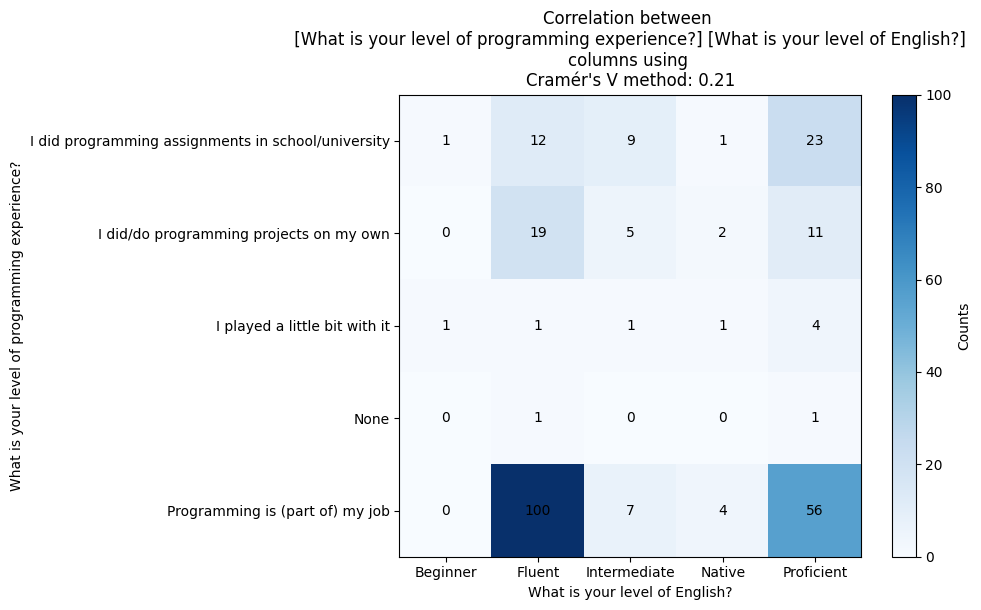

In [27]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np
import matplotlib.pyplot as plt

# Columns
FIRST_QUESTION = "What is your level of programming experience?"
SECOND_QUESTION = "What is your level of English?"

"""
We are using Cramér's V method to measure association between two categorical variables 
to recude the introduced bias between values which would appear when using Pearson correlation method
"""

# Compute a frequency table
freq_table = pd.crosstab(rf[FIRST_QUESTION], rf[SECOND_QUESTION])

# Perform the Chi-square test
chi2, p, dof, expected = chi2_contingency(freq_table)

# Calculate Cramer's V
n = freq_table.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(freq_table.shape) - 1)))

print(f"Cramer's V: {cramers_v}")

# Create a 2D histogram with Matplotlib
plt.figure(figsize=(8, 6))

# Visualize the frequency table as a heatmap
plt.imshow(freq_table, cmap='Blues', interpolation='nearest')

# Add a color bar
plt.colorbar(label='Counts')

# Add labels for the axes
plt.xticks(ticks=np.arange(len(freq_table.columns)), labels=freq_table.columns)
plt.yticks(ticks=np.arange(len(freq_table.index)), labels=freq_table.index)

# Add labels and title
plt.xlabel(SECOND_QUESTION)
plt.ylabel(FIRST_QUESTION)
plt.title(f'Correlation between \n [{FIRST_QUESTION}] [{SECOND_QUESTION}] \ncolumns using \nCramér\'s V method: {cramers_v:.2f}')

# Annotate the cells with the frequency counts
for i in range(len(freq_table.index)):
    for j in range(len(freq_table.columns)):
        count = freq_table.iloc[i, j]
        plt.text(j, i, f'{count}', ha='center', va='center', color='black')

# Show the plot
plt.show()